<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/MLPU001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import division, print_function
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve

# 数据准备



In [2]:
N = 6000
known_labels_ratio = 0.1
X, y = make_moons(n_samples=N, noise=0.1, shuffle=True)
#将输入的数据进行随机排列（此函数只能针对一维数据随机排列）
#如果函数输入参数x是一个整数
#返回从0到x-1的随机排列数组
rp = np.random.permutation(int(N/2))
data_P = X[y==1][rp[:int(len(rp)*known_labels_ratio)]]
print("data_P shape: ",data_P.shape)
data_U = np.concatenate((X[y==1][rp[int(len(rp)*known_labels_ratio):]], X[y==0]), axis=0)
print("data_U shape: ",data_U.shape)

print("Amount of labeled samples: %d" % (data_P.shape[0]))


data_P shape:  (300, 2)
data_U shape:  (5700, 2)
Amount of labeled samples: 300


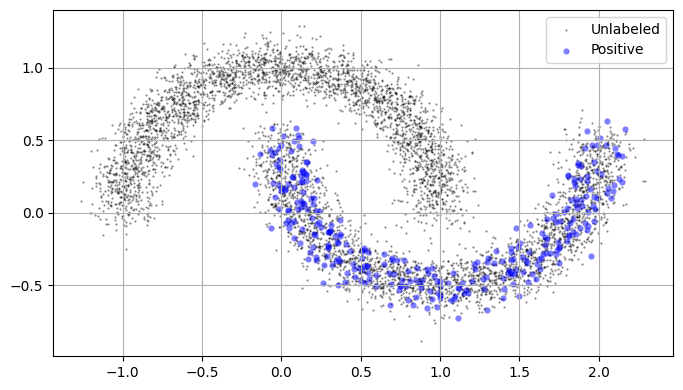

In [3]:
plt.figure(figsize=(8, 4.5))
plt.scatter(data_U[:, 0], data_U[:, 1], c='k', marker='.', linewidth=1, s=1, alpha=0.5, label='Unlabeled')
plt.scatter(data_P[:, 0], data_P[:, 1], c='b', marker='o', linewidth=0, s=20, alpha=0.5, label='Positive')
plt.grid()
plt.legend()

# 直推学习
Transductive PU learning

* 自助样本（bootstrapped sample）

原始数据集有放回抽样产生的样本，和同一个分布中抽取多个样本相似。


* 袋外观测数据

某次迭代中没有选中的观测数据称为袋外（out-of-bag/OOB）观测数据



* 装袋（bagging）

1. 自助聚合的简写（bootstrap aggregation）

2. 使用同一个数据集的不同样本来训练一个模型的多个版本，分类这些模型就投票，回归就取平均值

* 增强（boosting）

0. 训练一系列模型，并给没有正确分类或远离其预测值的观测数据分配权重，以便后续训练的模型把它们放到优先地位


An ensemble of decision trees are trained using bagging. Each tree is trained with the whole positive set and a bootstrapped sample of the unlabeled set. Each tree evaluates its out-of-the-bag (oob) samples and makes a prediction. The predictions are averaged essentially transducing the labels to the whole unlabeled set.


The sensible parameters are

* T: The number of weak learners of the ensemble
* K: The size of the random bootstrap sample
* The parameters of the weak learner

Note: In the original paper the weak learner of choice was linear support vector machine.

In [4]:
#正样本数量
NP = data_P.shape[0]
#未标记样本数量
NU = data_U.shape[0]

T = 1000
K = NP
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0

#记录袋外样本（未标注）预测次数
n_oob = np.zeros(shape=(NU,))
#记录袋外样本（未标注）预测结果
f_oob = np.zeros(shape=(NU, 2))


for i in range(T):
    # Bootstrap resample
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    # Positive set + bootstrapped unlabeled set
    data_bootstrap = np.concatenate((data_P, data_U[bootstrap_sample, :]), axis=0)
    # Train model
    model = DecisionTreeClassifier(max_depth=None, max_features=None,
                                   criterion='gini', class_weight='balanced')
    model.fit(data_bootstrap, train_label)
    # Index for the out of the bag (oob) samples
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    # Transductive learning of oob samples
    f_oob[idx_oob] += model.predict_proba(data_U[idx_oob])
    n_oob[idx_oob] += 1
predict_proba = f_oob[:, 1]/n_oob

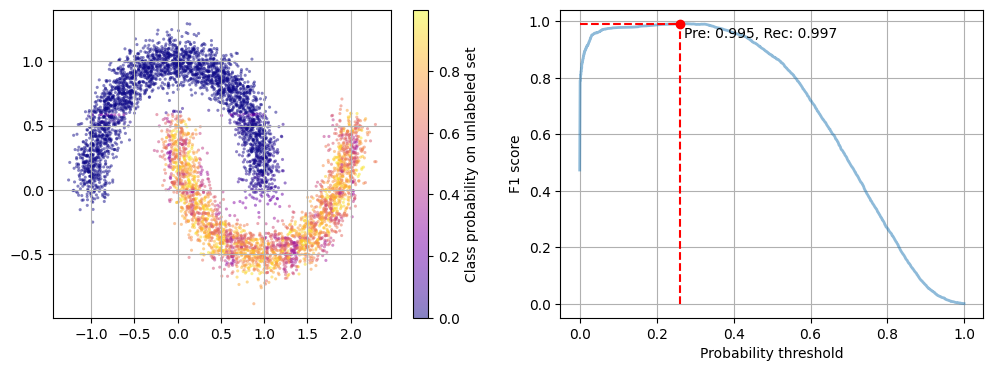

In [5]:
# Plot the class probabilities for the unlabeled samples
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 2, 1)
sp= ax1.scatter(data_U[:, 0], data_U[:, 1], c=predict_proba,
                linewidth=0, s=5, alpha=0.5, cmap=plt.cm.plasma, label='unlabeled')
plt.grid()
plt.colorbar(sp, label='Class probability on unlabeled set')

true_labels = np.zeros(shape=(data_U.shape[0]))
true_labels[:int(len(rp)*(1.0-known_labels_ratio))] = 1.0
precision, recall, th = precision_recall_curve(true_labels, predict_proba)
ax2 = fig.add_subplot(1, 2, 2)
f1s = precision[:-1]*recall[:-1]
ax2.plot(th, f1s, linewidth=2, alpha=0.5)
best_th = np.argmax(f1s)
ax2.plot(th[best_th], f1s[best_th], c='r', marker='o')
ax2.plot([th[best_th], th[best_th]], [0.0,f1s[best_th] ], 'r--')
ax2.plot([0.0, th[best_th]], [f1s[best_th], f1s[best_th] ], 'r--')
ax2.annotate('Pre: %0.3f, Rec: %0.3f' %(precision[best_th], recall[best_th]),
             xy=(th[best_th]+ 0.01, f1s[best_th]-0.05))
ax2.set_ylabel('F1 score')
ax2.set_xlabel('Probability threshold')
plt.grid()

In [6]:
N = 100000
known_labels_ratio = 0.01
X, y = make_moons(n_samples=N, noise=0.1, shuffle=True)
#将输入的数据进行随机排列（此函数只能针对一维数据随机排列）
#如果函数输入参数x是一个整数
#返回从0到x-1的随机排列数组
rp = np.random.permutation(int(N/2))
data_P = X[y==1][rp[:int(len(rp)*known_labels_ratio)]]
print("data_P shape: ",data_P.shape)
data_U = np.concatenate((X[y==1][rp[int(len(rp)*known_labels_ratio):]], X[y==0]), axis=0)
print("data_U shape: ",data_U.shape)

print("Amount of labeled samples: %d" % (data_P.shape[0]))


data_P shape:  (500, 2)
data_U shape:  (99500, 2)
Amount of labeled samples: 500


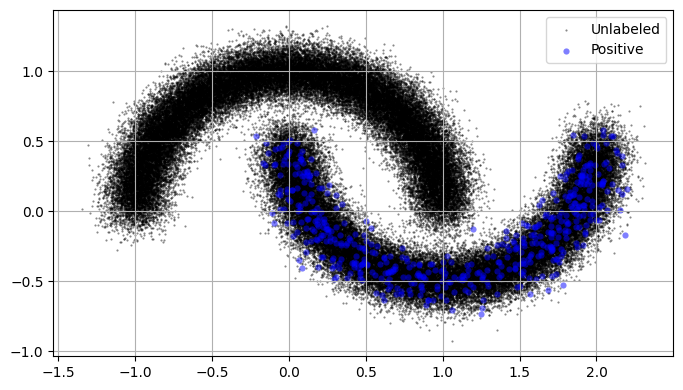

In [7]:
plt.figure(figsize=(8, 4.5))
plt.scatter(data_U[:, 0], data_U[:, 1], c='k', marker='.', linewidth=1, s=1, alpha=0.5, label='Unlabeled')
plt.scatter(data_P[:, 0], data_P[:, 1], c='b', marker='o', linewidth=0, s=20, alpha=0.5, label='Positive')
plt.grid()
plt.legend()

In [8]:
#正样本数量
NP = data_P.shape[0]
#未标记样本数量
NU = data_U.shape[0]

T = 1000
K = NP
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0

#记录袋外样本（未标注）预测次数
n_oob = np.zeros(shape=(NU,))
#记录袋外样本（未标注）预测结果
f_oob = np.zeros(shape=(NU, 2))


for i in range(T):
    # Bootstrap resample
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    # Positive set + bootstrapped unlabeled set
    data_bootstrap = np.concatenate((data_P, data_U[bootstrap_sample, :]), axis=0)
    # Train model
    model = DecisionTreeClassifier(max_depth=None, max_features=None,
                                   criterion='gini', class_weight='balanced')
    model.fit(data_bootstrap, train_label)
    # Index for the out of the bag (oob) samples
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    # Transductive learning of oob samples
    f_oob[idx_oob] += model.predict_proba(data_U[idx_oob])
    n_oob[idx_oob] += 1
predict_proba = f_oob[:, 1]/n_oob

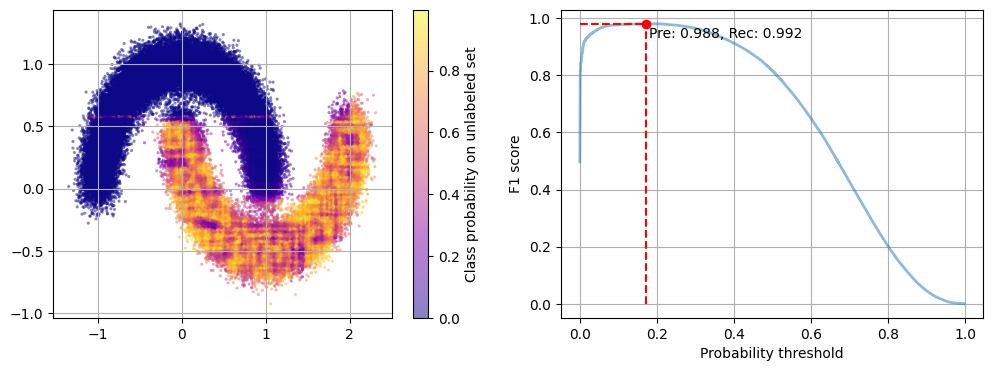

In [9]:
# Plot the class probabilities for the unlabeled samples
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 2, 1)
sp= ax1.scatter(data_U[:, 0], data_U[:, 1], c=predict_proba,
                linewidth=0, s=5, alpha=0.5, cmap=plt.cm.plasma, label='unlabeled')
plt.grid()
plt.colorbar(sp, label='Class probability on unlabeled set')

true_labels = np.zeros(shape=(data_U.shape[0]))
true_labels[:int(len(rp)*(1.0-known_labels_ratio))] = 1.0
precision, recall, th = precision_recall_curve(true_labels, predict_proba)
ax2 = fig.add_subplot(1, 2, 2)
f1s = precision[:-1]*recall[:-1]
ax2.plot(th, f1s, linewidth=2, alpha=0.5)
best_th = np.argmax(f1s)
ax2.plot(th[best_th], f1s[best_th], c='r', marker='o')
ax2.plot([th[best_th], th[best_th]], [0.0,f1s[best_th] ], 'r--')
ax2.plot([0.0, th[best_th]], [f1s[best_th], f1s[best_th] ], 'r--')
ax2.annotate('Pre: %0.3f, Rec: %0.3f' %(precision[best_th], recall[best_th]),
             xy=(th[best_th]+ 0.01, f1s[best_th]-0.05))
ax2.set_ylabel('F1 score')
ax2.set_xlabel('Probability threshold')
plt.grid()